# 0 - IMPORTS

In [1]:
from build_dataset import Corpus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import BertForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer, BertForSequenceClassification
import xgboost as xgb
import shap
import language_tool_python

c:\Users\ialbuquerque\AppData\Local\miniconda3\envs\envBOT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 - LEITURA DOS DADOS

In [2]:
c = Corpus()
df = c.read_corpus()
df.shape

(4570, 5)

In [3]:
df[['C1', 'C2', 'C3', 'C4', 'C5']] = pd.DataFrame(df['competence'].tolist(), index=df.index)

# 2 - ENTENDIMENTO DOS DADOS

In [4]:
df.head()

,prompt,title,essay,competence,score,C1,C2,C3,C4,C5
0,21,A greve dos caminhoneiros e a malha ferroviária,[A grande importância dos caminhoneiros para o...,"[160, 160, 120, 120, 120]",680,160,160,120,120,120
1,23,"Vossa excelência Senador M. M.,",[O senhor e eu já estamos cientes do projeto d...,"[160, 160, 120, 120, 120]",680,160,160,120,120,120
2,39,A validade do impeachment,[É de conhecimento geral dos brasileiros o quã...,"[120, 160, 160, 160, 120]",720,120,160,160,160,120
3,26,Podemos perceber que a sociedade brasileira,[Podemos perceber que a sociedade brasileira e...,"[120, 120, 80, 120, 120]",560,120,120,80,120,120
4,4,Comenta-se que o ex-presidente Lula,[Comenta-se que o ex presidente Lula ex-presid...,"[0, 0, 0, 0, 0]",0,0,0,0,0,0


In [5]:
train, valid, test = c.read_splits()

In [6]:
# Valores Nulos
df.isna().sum()

prompt          0
title         684
essay           0
competence      0
score           0
C1              0
C2              0
C3              0
C4              0
C5              0
dtype: int64

In [7]:
# Descrição estatística dos dados
df.describe()

,prompt,score,C1,C2,C3,C4,C5
count,4570.000000,4570.000000,4570.000000,4570.000000,4570.000000,4570.000000,4570.000000
mean,55.420788,614.030635,127.737418,129.496718,113.356674,130.634573,112.805252
std,20.940869,176.878132,32.320365,39.879010,38.098571,42.401018,50.213457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,520.000000,120.000000,120.000000,80.000000,120.000000,80.000000
50%,56.000000,600.000000,120.000000,120.000000,120.000000,120.000000,120.000000
75%,73.000000,720.000000,160.000000,160.000000,120.000000,160.000000,160.000000
max,85.000000,1000.000000,200.000000,200.000000,200.000000,200.000000,200.000000


In [8]:
# Informações do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      4570 non-null   int64 
 1   title       3886 non-null   object
 2   essay       4570 non-null   object
 3   competence  4570 non-null   object
 4   score       4570 non-null   int64 
 5   C1          4570 non-null   int64 
 6   C2          4570 non-null   int64 
 7   C3          4570 non-null   int64 
 8   C4          4570 non-null   int64 
 9   C5          4570 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 357.2+ KB


# 3 - ANALISE EXPLORATÓRIA DOS DADOS

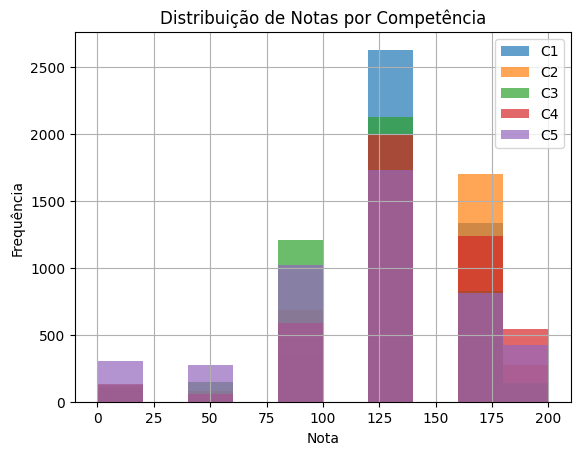

In [9]:
# Histograma para cada competência
competencias = ['C1', 'C2', 'C3', 'C4', 'C5']
for c in competencias:
    df[c].hist(bins=10, alpha=0.7, label=c)

plt.title('Distribuição de Notas por Competência')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.legend()
plt.show()

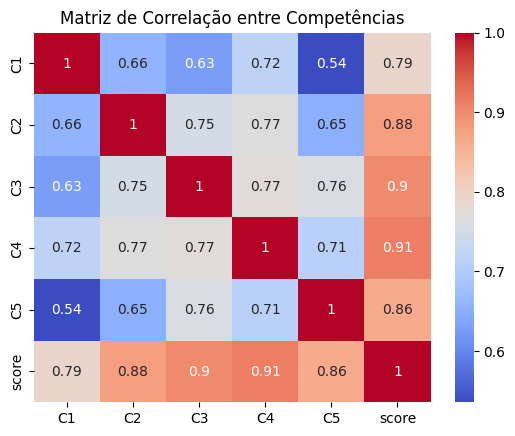

In [10]:
# Matriz de correlação
correlation_matrix = df[['C1', 'C2', 'C3', 'C4', 'C5', 'score']].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação entre Competências')
plt.show()


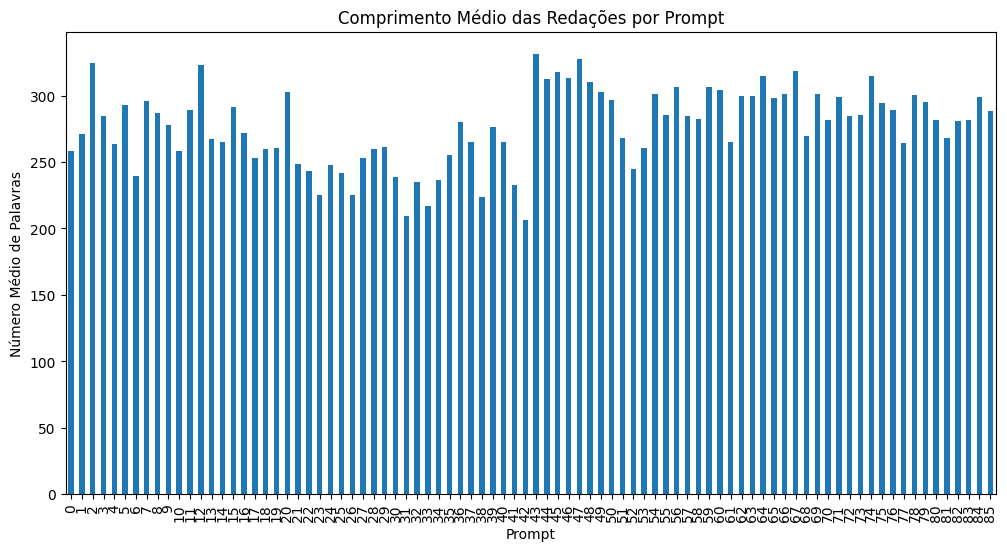

In [11]:
# Converter a coluna 'essay' para string
df['essay'] = df['essay'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Calcular o número de palavras
df['num_palavras'] = df['essay'].apply(lambda x: len(x.split()))

# Calcular a média de palavras por prompt
df.groupby('prompt')['num_palavras'].mean().plot(kind='bar', figsize=(12, 6))
plt.title('Comprimento Médio das Redações por Prompt')
plt.xlabel('Prompt')
plt.ylabel('Número Médio de Palavras')
plt.show()


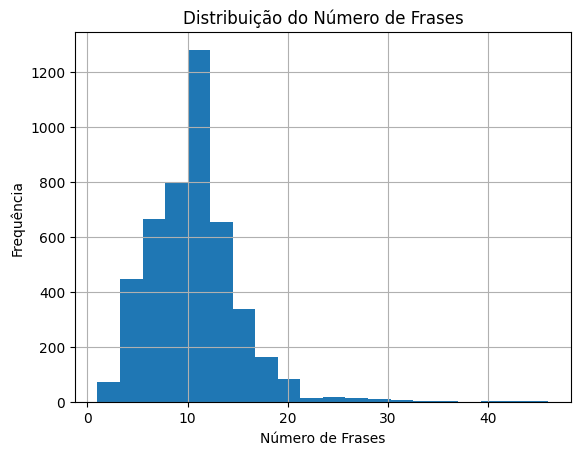

In [12]:
# Calcular o número de frases
df['num_frases'] = df['essay'].apply(lambda x: len(sent_tokenize(x)))

# Visualizar o histograma
df['num_frases'].hist(bins=20)
plt.title('Distribuição do Número de Frases')
plt.xlabel('Número de Frases')
plt.ylabel('Frequência')
plt.show()


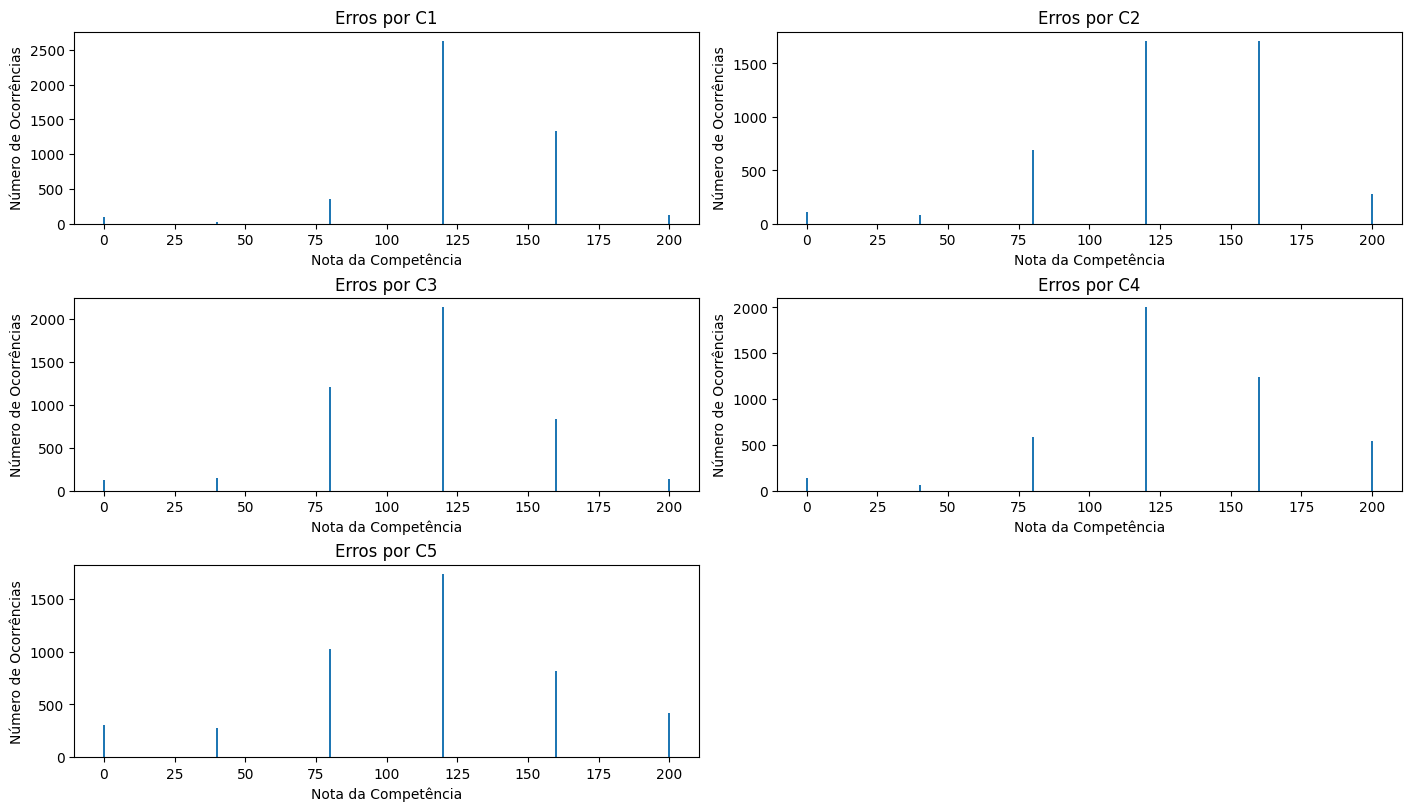

In [13]:
# Número de frequencia de ensaios agrupados por notas de competências 
competencias = ['C1', 'C2', 'C3', 'C4', 'C5']

# Configurações do layout (número de linhas e colunas)
num_colunas = 2
num_linhas = -(-len(competencias) // num_colunas)

# Criar subplots
fig, axes = plt.subplots(num_linhas, num_colunas, figsize=(14, 8), constrained_layout=True)

# Flatten os eixos para iterar
axes = axes.flatten()

# Loop pelas competências e geração dos gráficos
for i, competencia in enumerate(competencias):
    erros_por_competencia = df.groupby([competencia])['essay'].count()
    axes[i].bar(erros_por_competencia.index, erros_por_competencia.values)
    axes[i].set_title(f'Erros por {competencia}')
    axes[i].set_xlabel('Nota da Competência')
    axes[i].set_ylabel('Número de Ocorrências')

# Remover eixos vazios se o número de subplots for maior que o necessário
for j in range(len(competencias), len(axes)):
    fig.delaxes(axes[j])

plt.show()

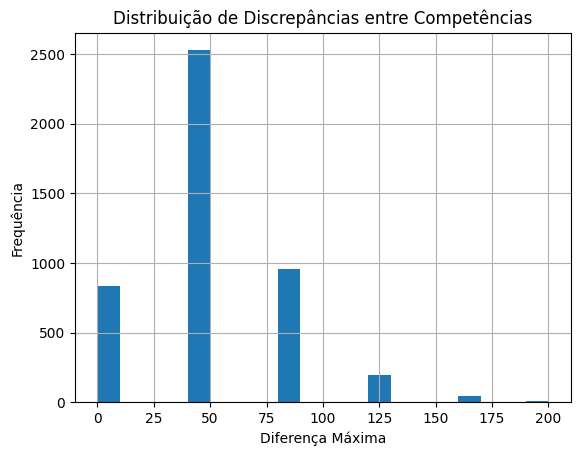

In [14]:
# Discrepancia entre as Competências
df['discrepancia'] = df[['C1', 'C2', 'C3', 'C4', 'C5']].max(axis=1) - df[['C1', 'C2', 'C3', 'C4', 'C5']].min(axis=1)
df['discrepancia'].hist(bins=20)
plt.title('Distribuição de Discrepâncias entre Competências')
plt.xlabel('Diferença Máxima')
plt.ylabel('Frequência')
plt.show()


In [15]:
# Visualização de prompts com 'score' menor que 200
notas_baixas = df[df['score'] < 200]
print(notas_baixas[['prompt', 'essay']].sample(5))

      prompt                                              essay
13        42  Eu acredito que os dois são muito importantes ...
3541      74  O eminicìdio no Brasil é um assunto muito impo...
1756      85  Frequentemente ouve-se falar de estupro, crime...
88        25  A homofobia vem aumentando diariamente, pratic...
608       38  Há tempos, observa-se que muitos médicos, cien...


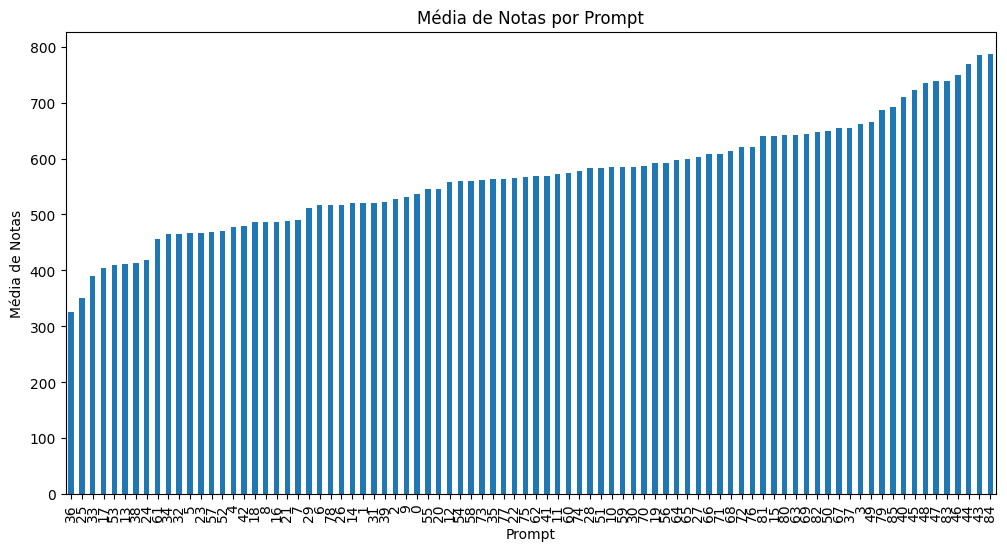

In [16]:
# Média das notas
prompt_mean_scores = df.groupby('prompt')['score'].mean().sort_values()
prompt_mean_scores.plot(kind='bar', figsize=(12, 6))
plt.title('Média de Notas por Prompt')
plt.xlabel('Prompt')
plt.ylabel('Média de Notas')
plt.show()


In [17]:
# Metrica MAE
X = df[['C1', 'C2', 'C3', 'C4', 'C5']]
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Erro Quadrático Médio: {mean_squared_error(y_test, y_pred)}")


Erro Quadrático Médio: 2.1485099379768327e-25


In [18]:
# Análise de frequência de palavras nos ensaios
palavras_altas = Counter(" ".join(df[df['score'] > 800]['essay']).split())
palavras_baixas = Counter(" ".join(df[df['score'] < 200]['essay']).split())

print("Palavras mais comuns em notas altas:", palavras_altas.most_common(10))
print("Palavras mais comuns em notas baixas:", palavras_baixas.most_common(10))

Palavras mais comuns em notas altas: [('de', 8206), ('a', 6522), ('que', 4723), ('o', 4682), ('e', 4268), ('do', 2514), ('da', 2326), ('para', 2163), ('é', 2159), ('em', 1858)]
Palavras mais comuns em notas baixas: [('de', 969), ('a', 826), ('que', 766), ('e', 741), ('o', 623), ('para', 324), ('é', 305), ('em', 280), ('do', 271), ('com', 268)]


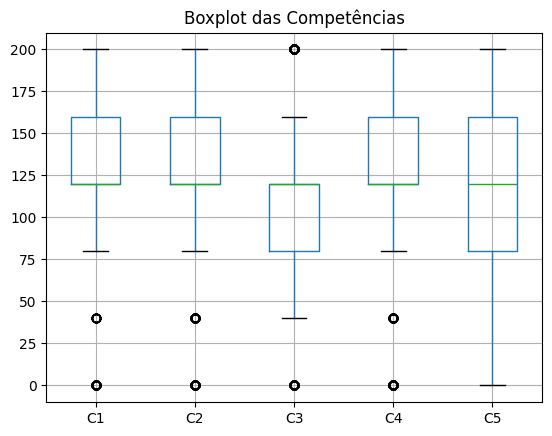

In [19]:
# Boxplot das competências

df[['C1', 'C2', 'C3', 'C4', 'C5']].boxplot()
plt.title('Boxplot das Competências')
plt.show()


In [20]:
# Limpar os textos dos ensaio
stop_words = set(stopwords.words('portuguese'))

df['clean_essay'] = df['essay'].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words]))


# 4 - MODELAGEM DE DADOS

In [21]:
# Modelo BERT pre-treinado
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
#Modelo GPT-2 para gerar um feedback automatizado

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

input_text = "A redação tem muitos erros gramaticais. Sugira melhorias."
inputs = tokenizer.encode(input_text, return_tensors="pt")
outputs = model.generate(inputs, max_length=50, num_return_sequences=1)
feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(feedback)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


A redação tem muitos erros gramaticais. Sugira melhorias.

The first time I saw the book was in the summer of 2010. I was in the middle of a trip to the beach with my


In [23]:
# MAE e R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Erro Absoluto Médio (MAE): {mae}")
print(f"Coeficiente de Determinação (R²): {r2}")


Erro Absoluto Médio (MAE): 3.115504450582251e-13
Coeficiente de Determinação (R²): 1.0


In [24]:
# Modelo Random Forest
rf_model = RandomForestRegressor()
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")


Melhores parâmetros: {'max_depth': 20, 'n_estimators': 200}


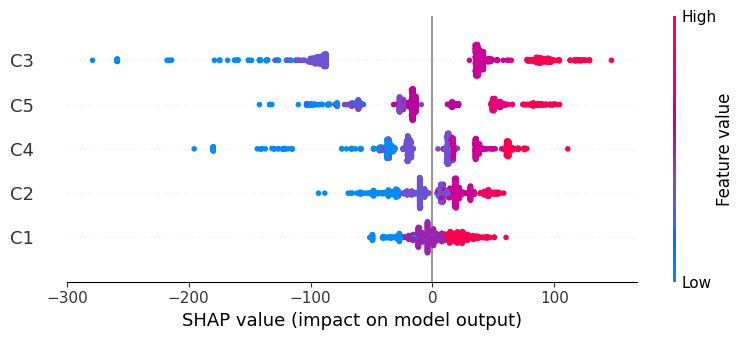

In [25]:
# Random Forest
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualizando os valores SHAP
shap.summary_plot(shap_values, X_test)

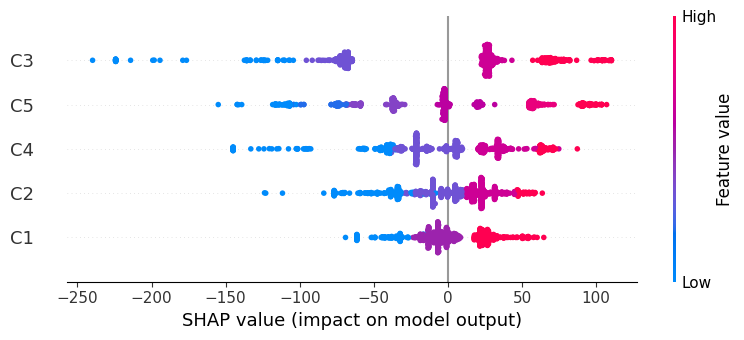

In [26]:
# Modeo XGBoost
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [27]:
# Cria um objeto CountVectorizer que extrairá bigramas e trigramas (ngram_range=(2,3))
vectorizer = CountVectorizer(ngram_range=(2, 3))

# Ajusta o vetor ao conjunto de ensaios e ao mesmo tempo transforma os textos em uma matriz de contagem de n-gramas
X_ngrams = vectorizer.fit_transform(df['clean_essay'])


In [28]:
# Cria uma instância da ferramenta de correção gramatical configurada para português do Brasil
tool = language_tool_python.LanguageTool('pt-BR')

def detect_errors(text):
    # Executa a checagem gramatical no texto fornecido
    matches = tool.check(text)
    # Retorna a contagem de erros (cada elemento em matches representa um erro encontrado)
    return len(matches)

# Aplica a função detect_errors a cada redação limpa, criando uma nova coluna com o número de erros gramaticais
df['grammatical_errors'] = df['clean_essay'].apply(detect_errors)


In [29]:
def lexical_diversity(text):
    # A função lexical_diversity calcula a diversidade lexical de um texto.
    # Diversidade lexical é a razão entre o número de palavras únicas e o número total de palavras.
    
    words = word_tokenize(text)
    # Aqui, word_tokenize(text) transforma a string 'text' em uma lista de palavras (tokens).

    # len(set(words)) retorna a contagem de palavras únicas do texto,
    # enquanto len(words) é a quantidade total de palavras.
    return len(set(words)) / len(words)


# Aplica a função lexical_diversity para cada redação (coluna 'clean_essay') do DataFrame df.
# O resultado é uma nova coluna 'lexical_diversity' que contém, para cada redação, 
# um valor entre 0 e 1, indicando o quão diversificado é o vocabulário utilizado.
df['lexical_diversity'] = df['clean_essay'].apply(lexical_diversity)


In [30]:
def count_connectors(text):
    # Define uma lista de conectores discursivos que desejamos contar no texto
    connectors = ['portanto', 'logo', 'assim', 'além disso', 'por outro lado']
    
    # Retorna a soma da ocorrência dos conectores no texto.
    # 'sum(word in text for word in connectors)' faz uma iteração implícita:
    # Para cada elemento em 'connectors', verifica se 'word' está presente em 'text'.
    # 'word in text' retorna um valor booleano (True ou False).
    # True é convertido para 1 quando somado, e False para 0.
    return sum(word in text for word in connectors)


# Aplica a função 'count_connectors' a cada texto na coluna 'clean_essay' do DataFrame 'df'.
# Cria-se assim uma nova coluna 'connectors' que armazena o número de conectores discursivos
# detectados em cada redação.
df['connectors'] = df['clean_essay'].apply(count_connectors)


In [31]:
def correct_text(text):
    # A função correct_text recebe um texto e utiliza a ferramenta LanguageTool
    
    matches = tool.check(text)
    # 'tool.check(text)' retorna uma lista de objetos que descrevem os erros encontrados no texto.
    # Cada objeto em 'matches' contém informações como a posição do erro, 
    # a sugestão de correção, a gravidade do erro, etc.

    # 'language_tool_python.utils.correct' utiliza a lista de erros 'matches'
    # para produzir uma versão corrigida do texto.
    return language_tool_python.utils.correct(text, matches)


# Aplica a função correct_text em cada redação (coluna 'clean_essay') do DataFrame 'df'.
# Assim, cria-se uma nova coluna 'corrected_essay' que contém uma versão corrigida
# de cada redação, levando em conta as sugestões da ferramenta LanguageTool.
df['corrected_essay'] = df['clean_essay'].apply(correct_text)


In [32]:
def gerar_feedback(row):
    feedback = []

    # Regras para C1: Gramática e ortografia
    if row['C1'] < 100:
        feedback.append("A redação apresenta muitos erros gramaticais e ortográficos. Tente revisar com atenção às regras da Língua Portuguesa.")
    
    # Regras para C2: Tema e gênero textual
    if row['C2'] < 100:
        feedback.append("A redação está pouco alinhada ao tema e ao gênero textual exigido. Releia a proposta e ajuste seu texto.")
    
    # Regras para C3: Coerência argumentativa
    if row['C3'] < 100:
        feedback.append("A argumentação não está clara ou bem estruturada. Tente desenvolver suas ideias com mais clareza e lógica.")
    
    # Regras para C4: Coesão textual
    if row['C4'] < 100:
        feedback.append("Faltam conectores e transições suaves entre as partes do texto. Tente usar conectores como 'portanto', 'assim', 'além disso'.")
    
    # Regras para C5: Proposta de intervenção
    if row['C5'] < 100:
        feedback.append("A proposta de intervenção está incompleta ou pouco prática. Certifique-se de detalhar o 'como', 'quem' e 'onde' na solução.")
    
    return " ".join(feedback)

# Aplicar às redações
df['feedback'] = df.apply(gerar_feedback, axis=1)

# Exemplo de saída
print(df[['clean_essay', 'feedback']].head())


                                         clean_essay  \
0  grande importância caminhoneiros país perceptí...   
1  senhor cientes projeto lei favorável remoção r...   
2  conhecimento geral brasileiros quão debilitado...   
3  podemos perceber sociedade brasileira enfrenta...   
4  ex presidente lula lula ano 2016 após decisão ...   

                                            feedback  
0                                                     
1                                                     
2                                                     
3  A argumentação não está clara ou bem estrutura...  
4  A redação apresenta muitos erros gramaticais e...  


In [33]:
# Conectores

def contar_conectores(text):
    conectores = ['portanto', 'logo', 'assim', 'além disso', 'por outro lado', 'entretanto', 'contudo', 'todavia']
    palavras = text.lower().split()
    return sum(palavra in conectores for palavra in palavras)

# Adicionar uma coluna de conectores
df['num_conectores'] = df['essay'].apply(contar_conectores)

# Feedback baseado nos conectores
def feedback_conectores(row):
    if row['num_conectores'] < 3:
        return "A redação usa poucos conectores discursivos. Considere adicionar palavras como 'portanto', 'além disso' para melhorar a coesão."
    return ""

# Combinar com feedback geral
df['feedback'] += df.apply(feedback_conectores, axis=1)

# Exemplo de saída
print(df[['clean_essay', 'num_conectores', 'feedback']].head())

                                         clean_essay  num_conectores  \
0  grande importância caminhoneiros país perceptí...               1   
1  senhor cientes projeto lei favorável remoção r...               0   
2  conhecimento geral brasileiros quão debilitado...               1   
3  podemos perceber sociedade brasileira enfrenta...               0   
4  ex presidente lula lula ano 2016 após decisão ...               1   

                                            feedback  
0  A redação usa poucos conectores discursivos. C...  
1  A redação usa poucos conectores discursivos. C...  
2  A redação usa poucos conectores discursivos. C...  
3  A argumentação não está clara ou bem estrutura...  
4  A redação apresenta muitos erros gramaticais e...  


In [34]:
df.head()

,prompt,title,essay,competence,score,C1,C2,C3,C4,C5,num_palavras,num_frases,discrepancia,clean_essay,grammatical_errors,lexical_diversity,connectors,corrected_essay,feedback,num_conectores
0,21,A greve dos caminhoneiros e a malha ferroviária,A grande importância dos caminhoneiros para o ...,"[160, 160, 120, 120, 120]",680,160,160,120,120,120,341,12,40,grande importância caminhoneiros país perceptí...,10,0.809524,1,Grande importância caminhoneiro país perceptív...,A redação usa poucos conectores discursivos. C...,1
1,23,"Vossa excelência Senador M. M.,",O senhor e eu já estamos cientes do projeto de...,"[160, 160, 120, 120, 120]",680,160,160,120,120,120,233,8,40,senhor cientes projeto lei favorável remoção r...,14,0.795276,2,Senhor cientes projeto-lei favorável remoção r...,A redação usa poucos conectores discursivos. C...,0
2,39,A validade do impeachment,É de conhecimento geral dos brasileiros o quão...,"[120, 160, 160, 160, 120]",720,120,160,160,160,120,409,19,40,conhecimento geral brasileiros quão debilitado...,21,0.842795,1,Conhecimento geral brasileiro quão debilitado ...,A redação usa poucos conectores discursivos. C...,1
3,26,Podemos perceber que a sociedade brasileira,Podemos perceber que a sociedade brasileira en...,"[120, 120, 80, 120, 120]",560,120,120,80,120,120,207,7,40,podemos perceber sociedade brasileira enfrenta...,10,0.869919,0,Podemos perceber sociedade brasileira enfrenta...,A argumentação não está clara ou bem estrutura...,0
4,4,Comenta-se que o ex-presidente Lula,Comenta-se que o ex presidente Lula ex-preside...,"[0, 0, 0, 0, 0]",0,0,0,0,0,0,209,6,0,ex presidente lula lula ano 2016 após decisão ...,13,0.818898,2,Ex presidente lula ano 2016 após decisão supre...,A redação apresenta muitos erros gramaticais e...,1


In [39]:
df.to_excel('./results/essay_analisado.xlsx', index=False)